In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [112]:
train_df = pd.read_csv("covid19-global-forecasting-week-1/train.csv")
# test_df = pd.read_csv("covid19-global-forecasting-week-1/test.csv")

In [113]:
train_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [114]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [115]:
wuhan_data = train_df[(train_df['Country/Region']=='China') & (train_df['Province/State']=='Hubei')][['Date', 'ConfirmedCases']].set_index('Date')

In [116]:
wuhan_data.head()

,ConfirmedCases
Date,
2020-01-22,444.0
2020-01-23,444.0
2020-01-24,549.0
2020-01-25,761.0
2020-01-26,1058.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x134f74198>],
      dtype=object)

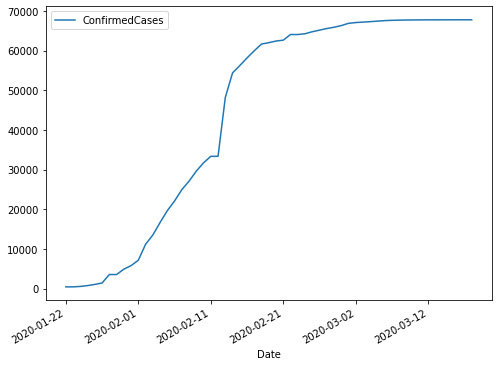

In [117]:
wuhan_data.plot(subplots=True)

In [119]:
wuhan_data_mean = wuhan_data.mean()
wuhan_data_std = wuhan_data.std()
wuhan_data = (wuhan_data - wuhan_data_mean) / wuhan_data_std
x_train_uni, y_train_uni = univariate_data(wuhan_data.values, 0, len(wuhan_data), 10, 0)

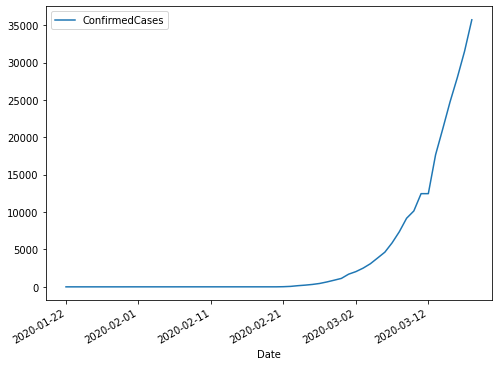

In [98]:
# italy data
italy_data = train_df[(train_df['Country/Region']=='Italy')][['Date', 'ConfirmedCases']].set_index('Date')
italy_data.plot(subplots=True)
italy_data.values

italy_data_mean = italy_data.mean()
italy_data_std = italy_data.std()
italy_data = (italy_data - italy_data_mean) / italy_data_std
x_train_uni, y_train_uni = univariate_data(italy_data.values, 0, len(italy_data), 10, 0)

In [120]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+2)*2])
    plt.xlabel('Time-Step')
    return plt

In [121]:
# show_plot([x_train_uni[-1], y_train_uni[-1]], 0, 'Sample Example')

In [136]:
y_train_uni[0]

array([-1.41952339])

In [122]:
len(x_train_uni)

47

In [123]:
# show_plot([x_train_uni[-1], y_train_uni[-1], np.mean(x_train_uni[-1])], 0,
#            'Baseline Prediction Example')

In [124]:
BATCH_SIZE = 12
BUFFER_SIZE = 50

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [125]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

In [126]:
EPOCHS = 30
simple_lstm_model.fit(train_univariate, steps_per_epoch=50, epochs=EPOCHS)

Train for 50 steps
Epoch 1/30
50/50 [==============================] - 2s 44ms/step - loss: 0.3195 - mae: 0.5335 - mse: 0.3196
Epoch 2/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0510 - mae: 0.1784 - mse: 0.0509
Epoch 3/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0170 - mae: 0.0733 - mse: 0.0170
Epoch 4/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0111 - mae: 0.0616 - mse: 0.0111
Epoch 5/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0082 - mae: 0.0568 - mse: 0.0082
Epoch 6/30
50/50 [==============================] - 0s 10ms/step - loss: 0.0072 - mae: 0.0555 - mse: 0.0072
Epoch 7/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0069 - mae: 0.0553 - mse: 0.0069
Epoch 8/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0069 - mae: 0.0557 - mse: 0.0069
Epoch 9/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0070 - mae: 0.0563 - mse: 0.0070
Epoch 10/30
5

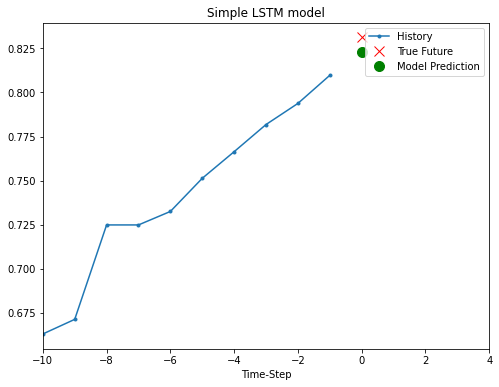

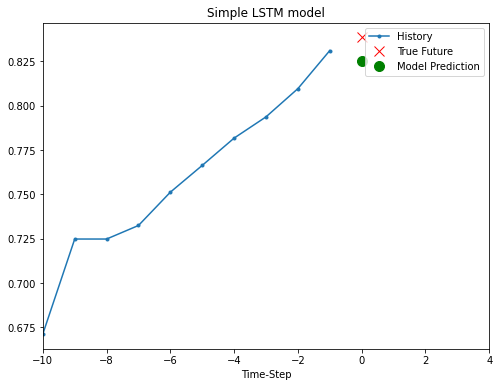

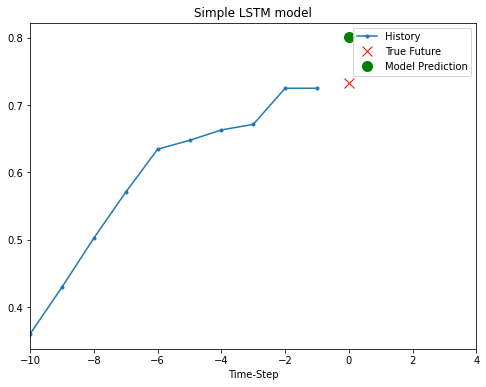

In [134]:
for x, y in train_univariate.shuffle(BUFFER_SIZE).take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()